# Predicting Quality Vinho Verde Wines
Claudia Hidrogo

## Data Set

The data set is the [Wine Quality data set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) from UCI's Machine Learning Repository. The data was donated from the University of Minho. The data is comprised of two tabular CSV files - one for red wines and another for white wines. There are 1599 red data points and 4898 data points for white. However, all data is from the DOC - Vinho Verde. There are no null values in this data set.

### Data Attributes 

There are a total of 12 attributes. There are 11 input variables and a single output variable. The attributes are as follows:

Input variables (based on physicochemical tests):

1 - fixed acidity

2 - volatile acidity

   3 - citric acid
   
   4 - residual sugar
   
   5 - chlorides
   
   6 - free sulfur dioxide
   
   7 - total sulfur dioxide
   
   8 - density
   
   9 - pH
   
   10 - sulphates
   
   11 - alcohol
   
   
   Output variable (based on sensory data): 
   
   12 - quality (score between 0 and 10; median of at least 3 evaluations made by wine experts

## Predictive Analysis

Our goal is to be able to predict the quality of a wine, given physicochemical features. ~~I would also like to see if there are distinct differences between the features of red and white wines that may cause the quality score to fluctuate. ~~~ After further exploratory analysis, I do not see much evidence to support that color drastically affects the quality of a wine. Instead, I would like to identify the main characteristics or features of a quality wine.

In [66]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm # use for regression parameter summary
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
# Set color map to have light blue background
sns.set()

In [3]:
red_wine = pd.read_csv('winequality-red.csv', delimiter=";") 
white_wine = pd.read_csv('winequality-white.csv', delimiter=";")

# EDA

### Red Wine: Quick look

In [4]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Text(0.5, 1.0, 'Distribution of Red Wine Quality')

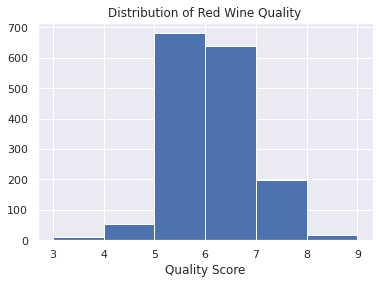

In [5]:
plt.hist(red_wine.quality, bins=range(3,10))
plt.xlabel("Quality Score")
plt.title("Distribution of Red Wine Quality")

### White Wine: Quick look

In [6]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Text(0.5, 1.0, 'Distribution of White Wine Quality')

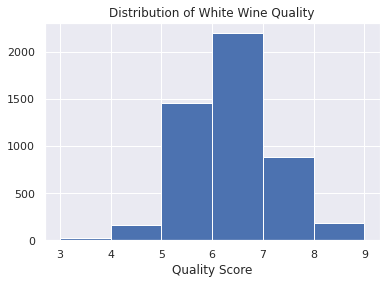

In [7]:
plt.hist(white_wine.quality, bins=range(3,10))
plt.xlabel("Quality Score")
plt.title("Distribution of White Wine Quality")

We notice that the number of samples between red and white wine are not the same; there are more white wine samples than red. This will need to be addressed.

### Combining the data 

In order to do a total analysis of the wine, I will combine the red and white wines into a single data frame. I will add a column `color` as a categorical data type with either a `red` or a `white` value. We will retain the original `red_wine` and `white_wine` for further analysis, if necessary.

In [8]:
red_wine['color'], white_wine['color'] = 'red', 'white'
wine = pd.concat([red_wine, white_wine], ignore_index=True)

Text(0.5, 1.0, 'Distribution of Overall Wine Quality')

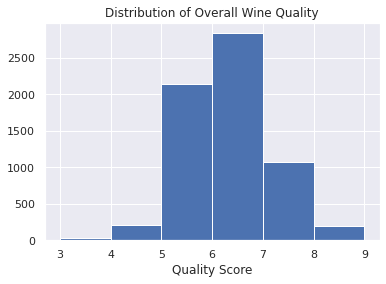

In [9]:
plt.hist(wine.quality, bins=range(3,10))
plt.xlabel("Quality Score")
plt.title("Distribution of Overall Wine Quality")

In [10]:
wine.columns = wine.columns.str.replace(' ', '_')
wine.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

## Exploring Influential Parameters

We use the r-squared statistic to tease out the top most influential features of our data set. We go through several 'rounds' of analysis. To utilize the power of Python we create a function to run analyses.

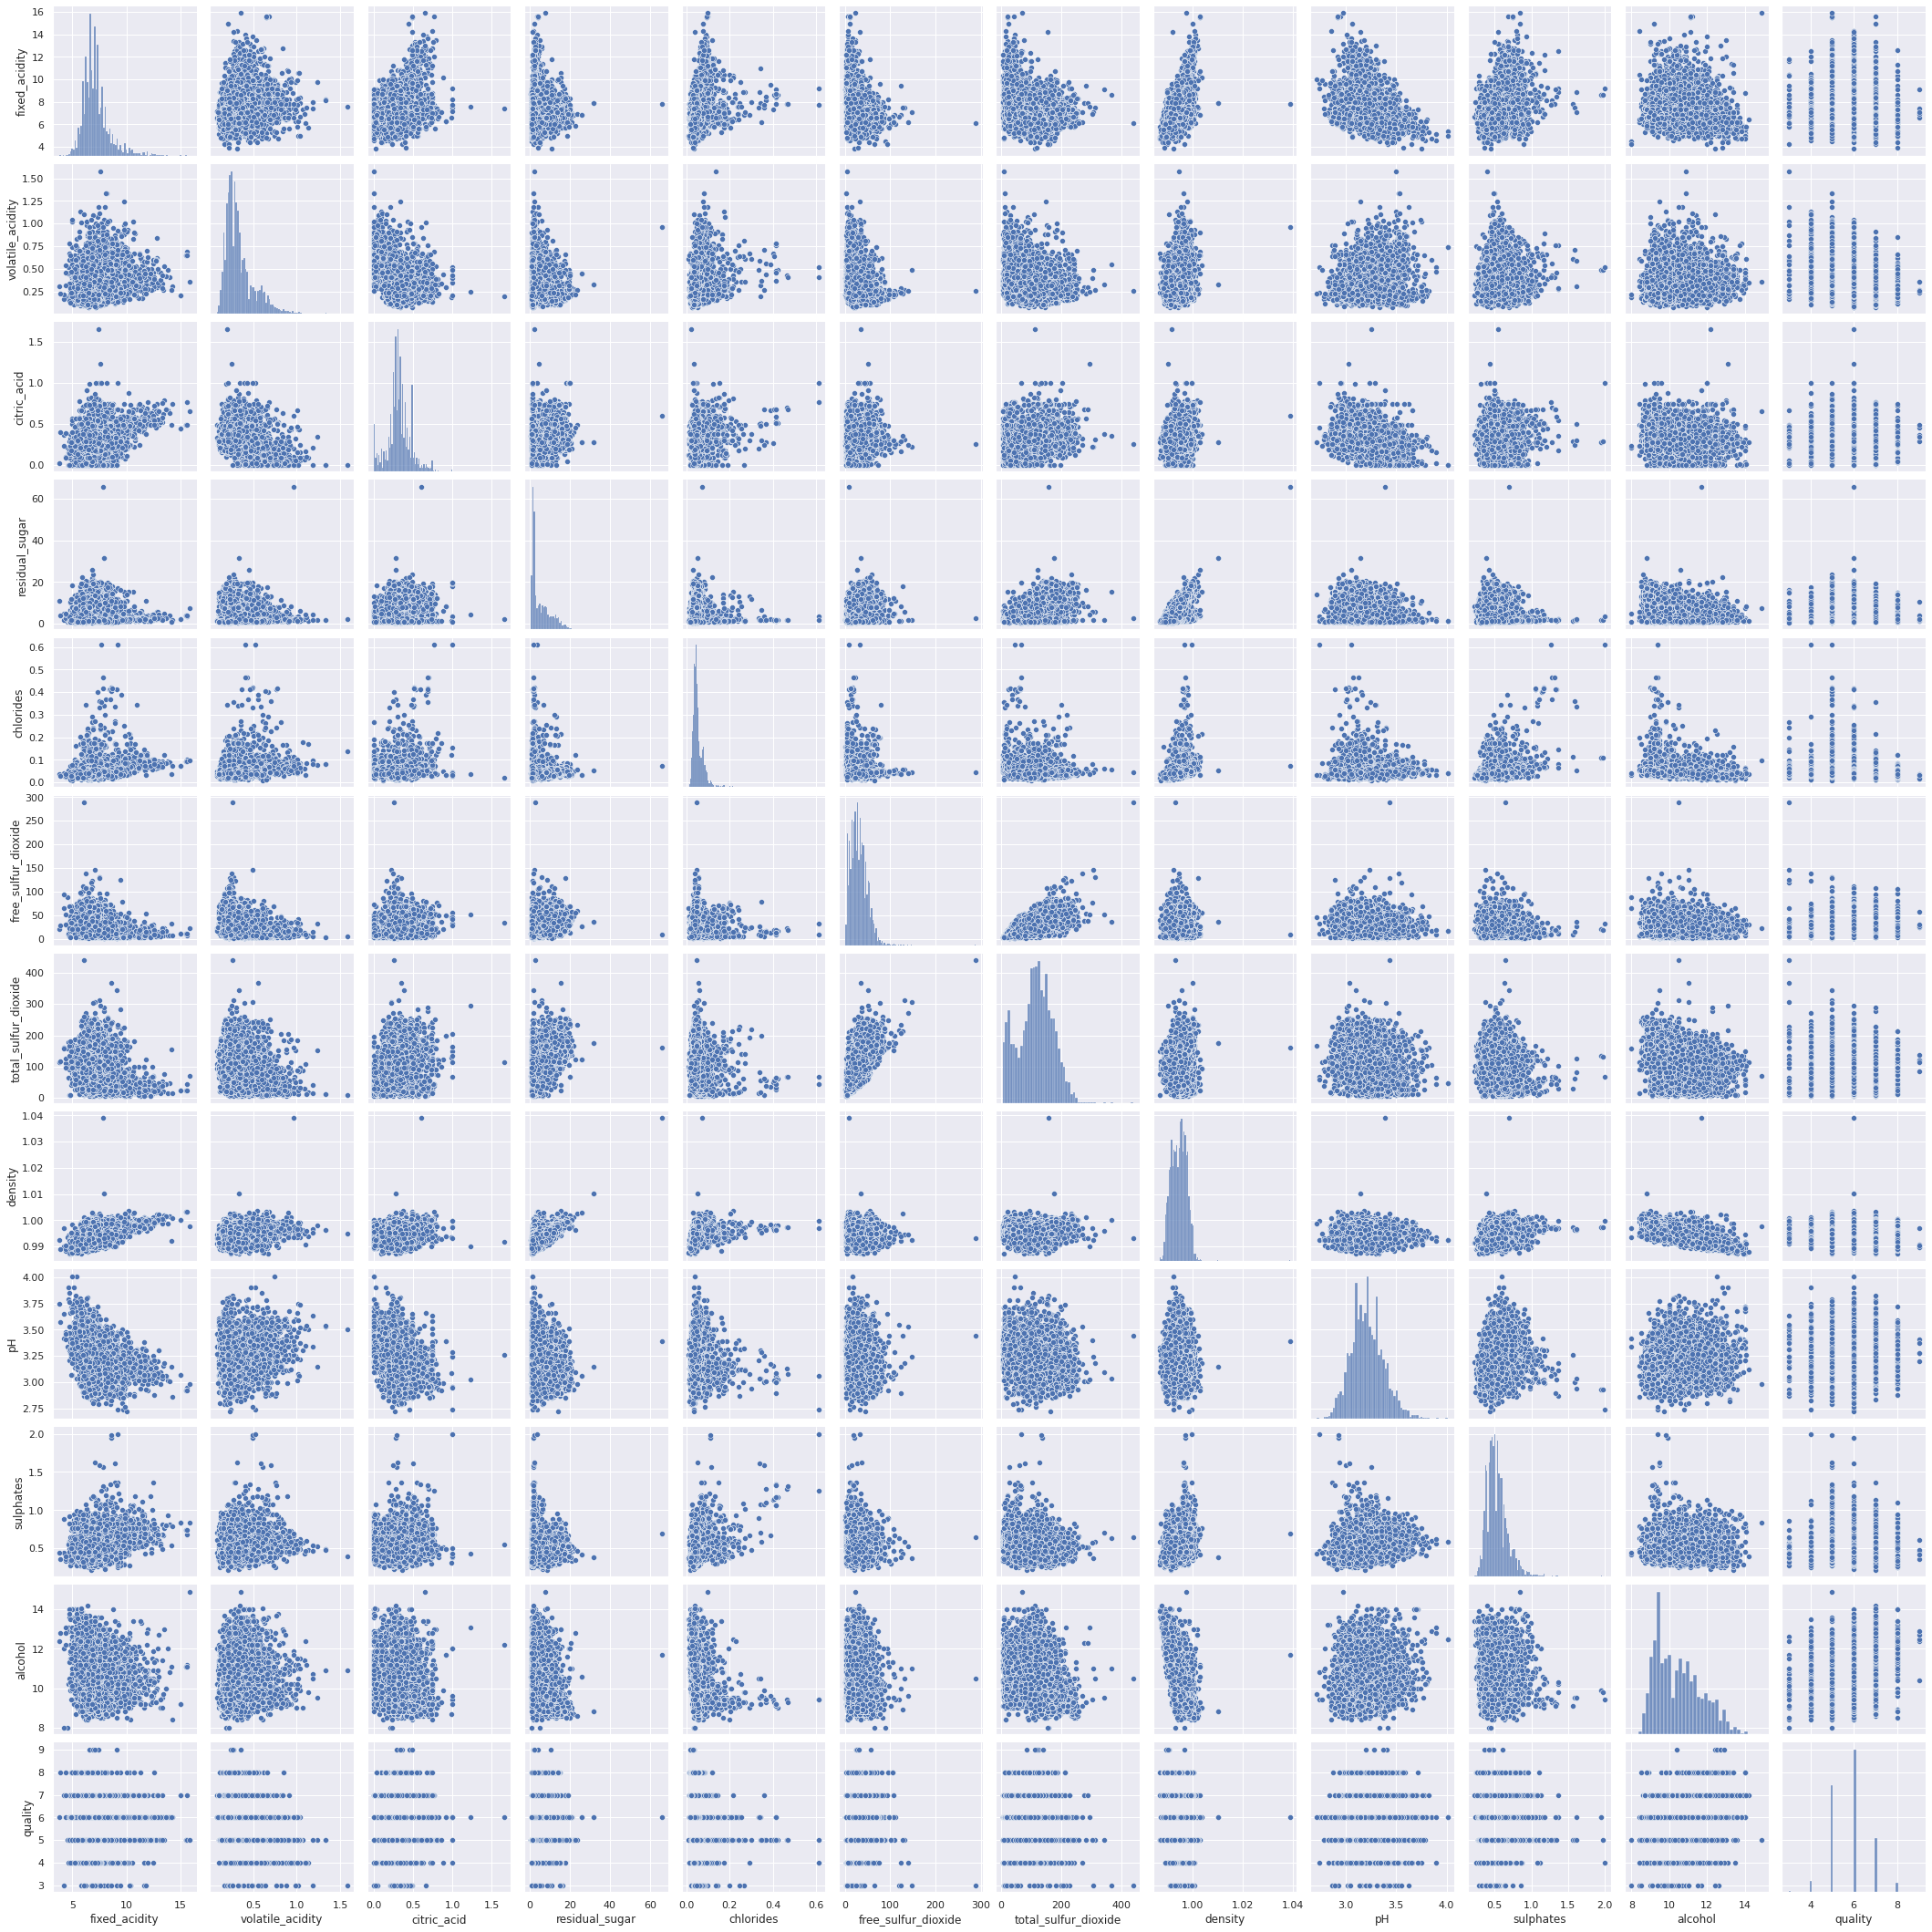

In [11]:
sns.pairplot(wine)

In [12]:

def get_r_squares(start_params=''):
    r_squared = {}
    start = ''
    
    test_params = list(wine.columns)

    # if user provides a list of parameters for model
    if len(start_params) == 1:
        start = start_params[0] + '+'
        test_params.remove(start_params[0])
    
    elif len(start_params) > 1:
        start = '+'.join(start_params) + '+'
        test_params = [param for param in test_params if param not in start_params]

    for col in test_params:
        if col != "quality":
            form = f'quality~{start}{col}'
            model = smf.ols(formula=form, data=wine).fit()
            r_squared[col] = model.rsquared
    
    return pd.DataFrame(sorted(list(r_squared.items()), key=lambda kv: kv[1], reverse=True), columns=['parameter', 'r-squared'])

We obtain our first look at potentially influential parameters:

In [13]:
param_df = get_r_squares()
print(param_df)

               parameter  r-squared
0                alcohol   0.197419
1                density   0.093549
2       volatile_acidity   0.070596
3              chlorides   0.040267
4                  color   0.014238
5            citric_acid   0.007316
6          fixed_acidity   0.005890
7    free_sulfur_dioxide   0.003076
8   total_sulfur_dioxide   0.001713
9              sulphates   0.001481
10        residual_sugar   0.001368
11                    pH   0.000380


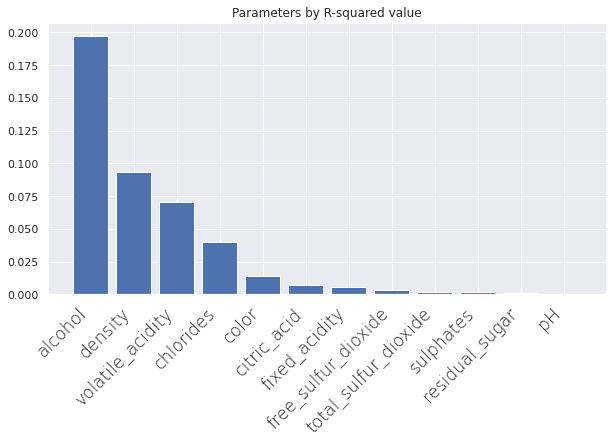

In [14]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('Parameters by R-squared value')
ax1.bar(np.arange(len(param_df)), param_df['r-squared'])
ax1.set_xticks(np.arange(len(param_df)))
ax1.set_xticklabels(param_df['parameter'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

As we can see, there are four main parameters that stick out: alcohol content, density, volitile acidity, and chlorides. We further test these four by adding an additional parameter to each of these four candidates to tease out further relationships.

#### Second Round

In [15]:
alcohol_models = get_r_squares(start_params=['alcohol'])
print(alcohol_models)

               parameter  r-squared
0       volatile_acidity   0.259496
1    free_sulfur_dioxide   0.216356
2         residual_sugar   0.214712
3                  color   0.208388
4            citric_acid   0.205555
5              chlorides   0.205432
6   total_sulfur_dioxide   0.203747
7              sulphates   0.199006
8                     pH   0.198618
9          fixed_acidity   0.198608
10               density   0.197420


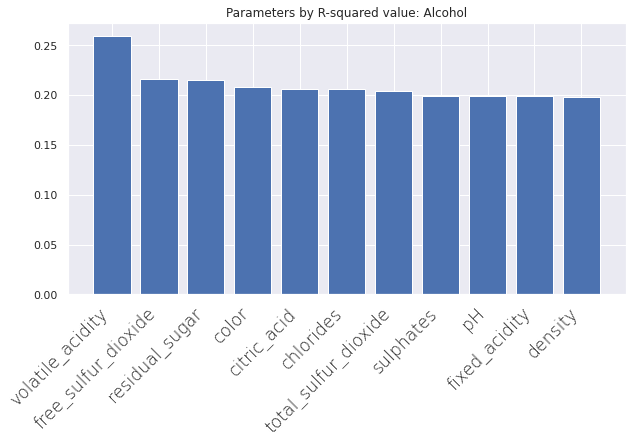

In [16]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('Parameters by R-squared value: Alcohol')
ax1.bar(np.arange(len(alcohol_models)), alcohol_models['r-squared'])
ax1.set_xticks(np.arange(len(alcohol_models)))
ax1.set_xticklabels(alcohol_models['parameter'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

               parameter  r-squared
0                alcohol   0.197420
1       volatile_acidity   0.129589
2         residual_sugar   0.118634
3              sulphates   0.108440
4            citric_acid   0.106884
5              chlorides   0.102825
6          fixed_acidity   0.098676
7    free_sulfur_dioxide   0.097562
8   total_sulfur_dioxide   0.094541
9                     pH   0.094082
10                 color   0.093549


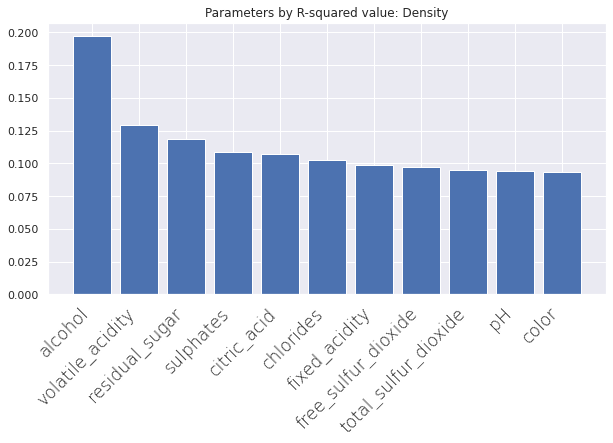

In [17]:
density_df = get_r_squares(start_params=['density'])
print(density_df)

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('Parameters by R-squared value: Density')
ax1.bar(np.arange(len(density_df)), density_df['r-squared'])
ax1.set_xticks(np.arange(len(density_df)))
ax1.set_xticklabels(density_df['parameter'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

               parameter  r-squared
0                alcohol   0.259496
1                density   0.129589
2   total_sulfur_dioxide   0.098314
3              chlorides   0.082363
4              sulphates   0.080827
5                     pH   0.079093
6         residual_sugar   0.078845
7                  color   0.075716
8    free_sulfur_dioxide   0.072264
9          fixed_acidity   0.070958
10           citric_acid   0.070855


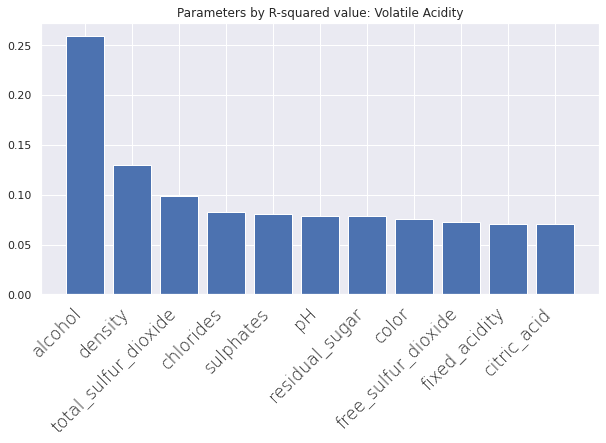

In [18]:
vol_acid_df = get_r_squares(start_params=['volatile_acidity'])
print(vol_acid_df)

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('Parameters by R-squared value: Volatile Acidity')
ax1.bar(np.arange(len(vol_acid_df)), vol_acid_df['r-squared'])
ax1.set_xticks(np.arange(len(vol_acid_df)))
ax1.set_xticklabels(vol_acid_df['parameter'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

               parameter  r-squared
0                alcohol   0.205432
1                density   0.102825
2       volatile_acidity   0.082363
3              sulphates   0.056737
4   total_sulfur_dioxide   0.050579
5            citric_acid   0.048995
6         residual_sugar   0.044284
7                     pH   0.041079
8                  color   0.040634
9          fixed_acidity   0.040580
10   free_sulfur_dioxide   0.040544


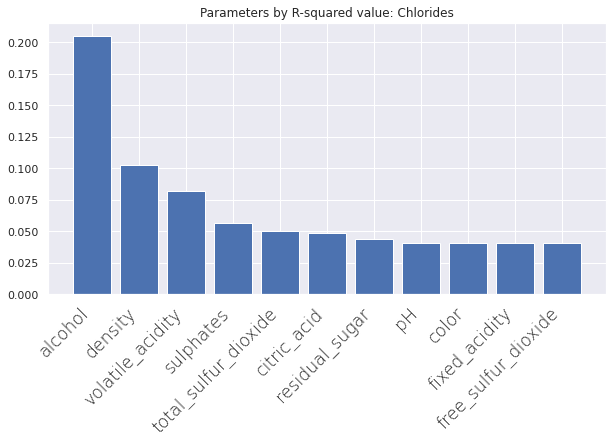

In [19]:
chlor_df = get_r_squares(start_params=['chlorides'])
print(chlor_df)

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('Parameters by R-squared value: Chlorides')
ax1.bar(np.arange(len(chlor_df)), chlor_df['r-squared'])
ax1.set_xticks(np.arange(len(chlor_df)))
ax1.set_xticklabels(chlor_df['parameter'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

After a brief look at corresponding parameter pairs, we see that alcohol content seems have the highest r-squared values in combination with other features. This leads us to believe that alcohol content impacts the quality of a wine. We check each wine quality score with their alcohol content, and seem to see a gentle positive correlation. 

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

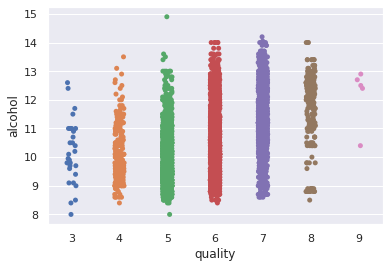

In [20]:
sns.stripplot(x="quality", y="alcohol", data=wine, jitter=True)

In [21]:
# param_list = list(wine.columns)
# param_list.remove('quality')
# param_str = '+'.join(param_list)
model = smf.ols(formula='quality~fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol+color', data=wine).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     227.8
Date:                Tue, 10 Aug 2021   Prob (F-statistic):               0.00
Time:                        01:52:48   Log-Likelihood:                -7195.2
No. Observations:                6497   AIC:                         1.442e+04
Df Residuals:                    6484   BIC:                         1.450e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              104.7518     14.136      7.411      0.000      77.041     132.462
color[T.white]          -0.3613      0.057     -6.367      0.000      -0.473      -0.250
fixed_acidity            0.0851      0.016      5.396      0.000       0.054       0.116
volatile_acidity        -1.4924      0.081    -18.345      0.000      -1.652      -1.333
citric_acid             -0.0626      0.080     -0.786      0.432      -0.219       0.094
residual_sugar           0.0624      0.006     10.522      0.000       0.051       0.074
chlorides               -0.7573      0.334     -2.264      0.024      -1.413      -0.102
free_sulfur_dioxide      0.0049      0.001      6.443      0.000       0.003       0.006
total_sulfur_dioxide    -0.0014      0.000     -4.333      0.000      -0.002      -0.001
density               -103.9096     14.336     -7.248      0.000    -132.013     -75.806
pH                       0.4988      0.091      5.506      0.000       0.321       0.676
sulphates                0.7217      0.076      9.466      0.000       0.572       0.871
alcohol                  0.2227      0.018     12.320      0.000       0.187       0.258
==============================================================================
Omnibus:                      140.992   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.985
Skew:                           0.016   Prob(JB):                     6.59e-69
Kurtosis:                       4.077   Cond. No.                     2.96e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
correlations = wine.corr()['quality'].drop('quality')
print(correlations)

fixed_acidity          -0.076743
volatile_acidity       -0.265699
citric_acid             0.085532
residual_sugar         -0.036980
chlorides              -0.200666
free_sulfur_dioxide     0.055463
total_sulfur_dioxide   -0.041385
density                -0.305858
pH                      0.019506
sulphates               0.038485
alcohol                 0.444319
Name: quality, dtype: float64


In [49]:
def get_features(correlation_threshold):
    abs_corrs = correlations.abs()
    high_correlations = []
    for cor in abs_corrs:
        if cor > correlation_threshold:
            high_correlations.append(cor)
    return high_correlations

In [58]:
features = get_features(0.09) 
print(features) 
x = wine[['volatile_acidity', 'chlorides', 'density', 'alcohol'] ]
y = wine['quality']

[0.2656994776114803, 0.20066550043510553, 0.30585790606941676, 0.44431852000766286]


Here we can see the four most correlated features: `volatile_acidity`, `chlorides`, `density`, and `alcohol`.

Text(0, 0.5, 'residuals')

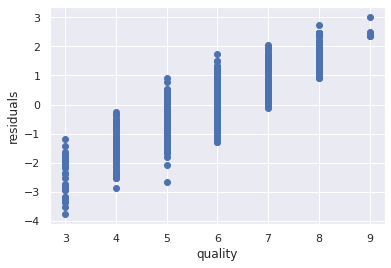

In [25]:
plt.plot(wine.quality, model.resid, 'o')
plt.xlabel('quality')
plt.ylabel('residuals')

In [24]:
wine.corr()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485


### Applying Preliminary Models

In [75]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3)

regres = sklearn.linear_model.LinearRegression()
regres.fit(x_train,y_train)

print(regres.coef_)

[-1.50863644 -0.37779495 38.37434028  0.38125507]


In [76]:
train_pred = regres.predict(x_train)
print(train_pred)
test_pred = regres.predict(x_test) 
print(test_pred)

[6.6839649  6.06454176 5.28481764 ... 6.41914929 5.09185386 5.62941812]
[5.97845561 5.24055855 4.9260118  ... 6.53505809 5.89721087 6.32344007]
